In [1]:
import importlib

import data_loading as load
import data_preprocessing as pre
import metrics

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import models

<module 'models' from 'd:\\Documents\\University\\Semester5\\ComputerVision\\fingerprint-inpainting\\models.py'>

## ResNet50 Transfer learning

In [2]:
input_func_list = []
truth_func_list = [pre.invert, pre.to_grayscale]

ds_factory = load.FingerprintDatasetFactory(input_func_list, truth_func_list, batch_size=4, seed=42)
train_ds = ds_factory("./small_data/training_input", "./small_data/training_truth")
test_ds = ds_factory("./small_data/validation_input", "./small_data/validation_truth")

Found 4000 files belonging to 1 classes.
Found 4000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.


In [3]:
input_batch, truth_batch = next(train_ds.as_numpy_iterator())

In [5]:
resnet_trans = models.get_mobilenet_transfer()
resnet_trans.compile(
    optimizer="adam",
    loss="mse"
)
resnet_trans.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 400, 275, 3)]     0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 256)         2212096   
                                                                 
 up_sampling2d (UpSampling2D  (None, 15, 15, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040

In [6]:
history = resnet_trans.fit(train_ds, validation_data=test_ds, epochs=1)

  51/1000 [>.............................] - ETA: 40:28 - loss: 8724.2529

KeyboardInterrupt: 

## Custom model

In [2]:
input_func_list = [pre.normalize_pixels]
truth_func_list = [pre.invert, pre.to_grayscale, pre.normalize_pixels]

ds_factory = load.FingerprintDatasetFactory(input_func_list, truth_func_list, batch_size=4, seed=42)
train_ds = ds_factory("./small_data/training_input", "./small_data/training_truth")
test_ds = ds_factory("./small_data/validation_input", "./small_data/validation_truth")

Found 4000 files belonging to 1 classes.
Found 4000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.


In [10]:
custom_model = models.get_custom_conv(conv_activation="relu", dense_activation="relu")

custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.MeanSquaredError()
)

custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 400, 275, 64)      1792      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 133, 91, 64)      0         
 2D)                                                             
                                                                 
 conv2d_23 (Conv2D)          (None, 133, 91, 128)      73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 44, 30, 128)      0         
 2D)                                                             
                                                                 
 conv2d_24 (Conv2D)          (None, 44, 30, 256)       295168    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 10, 256)     

In [18]:
resnet_base = tf.keras.applications.resnet50.ResNet50(include_top=False, input_shape=(400, 275, 3))
_ = tf.keras.utils.plot_model(resnet_base, "resnet_base.png", show_shapes=True)

In [11]:
history = custom_model.fit(train_ds, validation_data=test_ds, epochs=1)

Epoch 1/5
1000/1000 [==============================] - 508s 503ms/step - loss: 0.1702 - val_loss: 0.1708
Epoch 2/5
1000/1000 [==============================] - 508s 507ms/step - loss: 0.1704 - val_loss: 0.1709
Epoch 3/5
1000/1000 [==============================] - 1036s 1s/step - loss: 0.1705 - val_loss: 0.1710
Epoch 4/5
1000/1000 [==============================] - 1683s 2s/step - loss: 0.1706 - val_loss: 0.1711
Epoch 5/5
  39/1000 [>.............................] - ETA: 22:53 - loss: 0.1722

KeyboardInterrupt: 

In [14]:
PATH_TO_INPUT = "./data/training_input"
PATH_TO_TRUTH = "./data/training_ground-truth"
filenames = glob.glob("*", root_dir=PATH_TO_INPUT)

n_examples = 4
fnames = np.random.choice(filenames, n_examples)
imgs_input = np.array([cv2.imread(os.path.join(PATH_TO_INPUT, fname), cv2.IMREAD_UNCHANGED) for fname in fnames], dtype=np.float32) / 255
imgs_truth = 1 - np.array([cv2.imread(os.path.join(PATH_TO_TRUTH, fname), cv2.IMREAD_UNCHANGED) for fname in fnames], dtype=np.float32) / 255

1/1 [==============================] - 0s 347ms/step


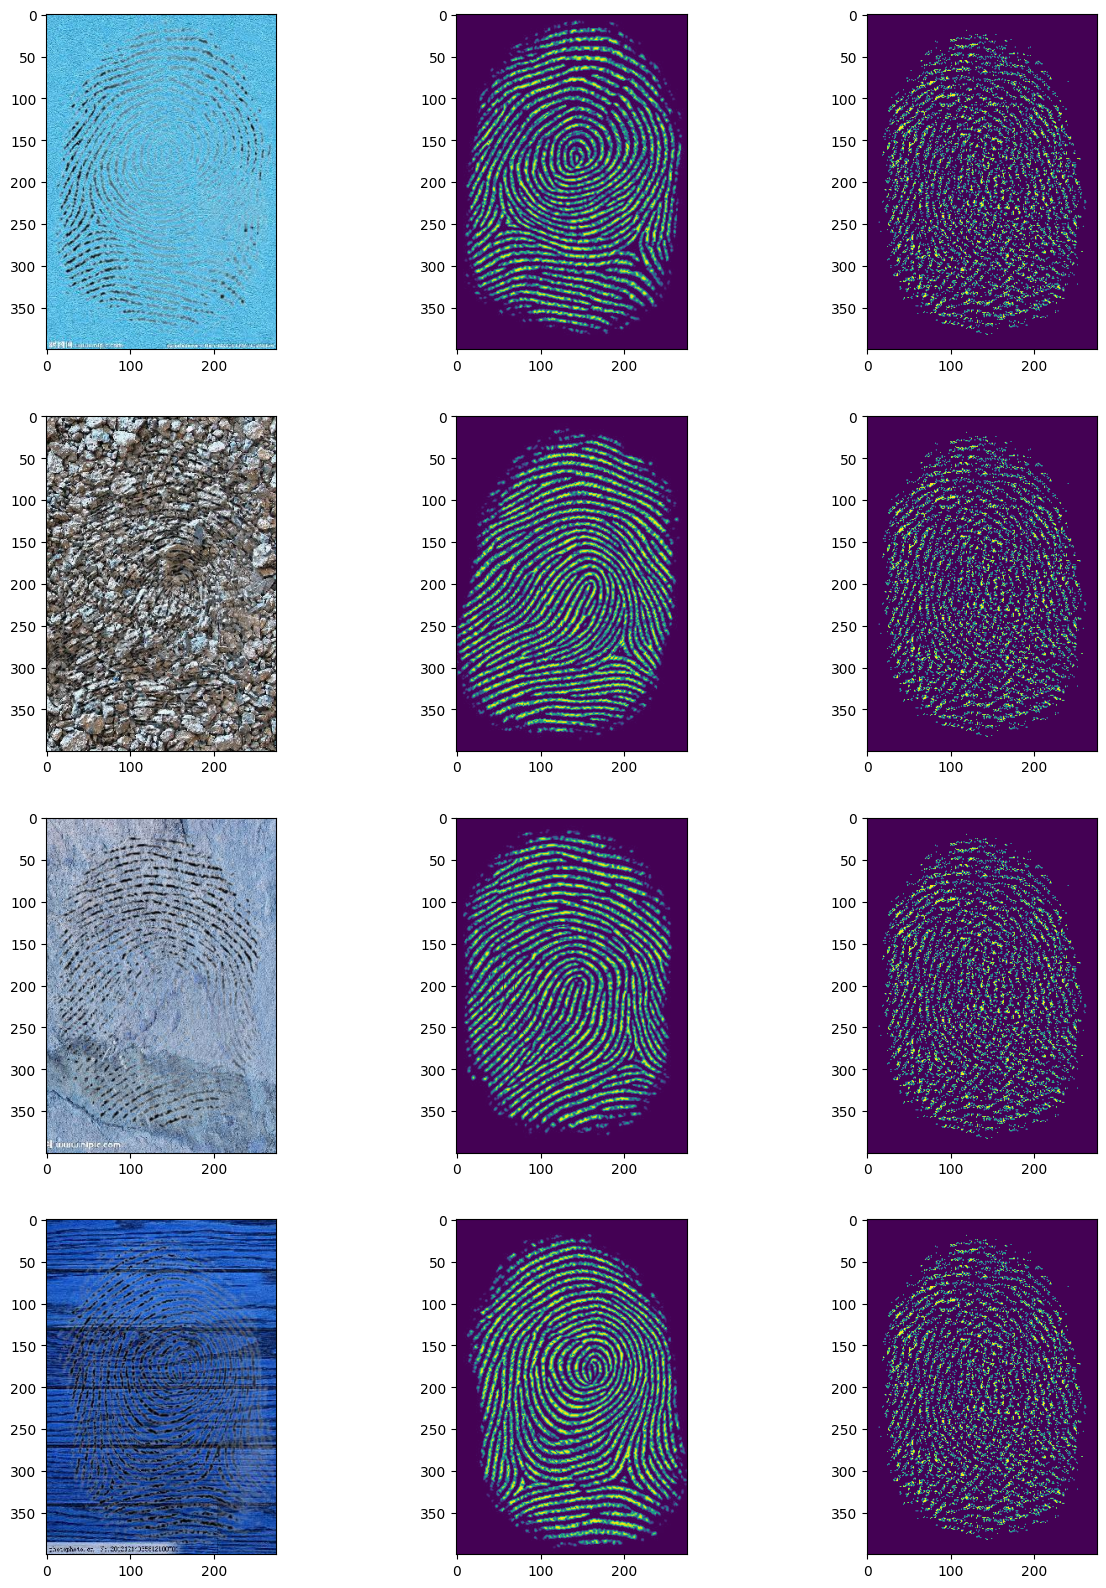

In [15]:
img_predict = custom_model.predict(imgs_input)


fig, axs = plt.subplots(n_examples, 3, figsize=(15, n_examples*5))
for i in range(n_examples):
    axs[i, 0].imshow(imgs_input[i])
    axs[i, 1].imshow(imgs_truth[i])
    axs[i, 2].imshow(img_predict[i])